# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: Linear GAN with MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import torchvision
import torchvision.transforms as T


import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_9196\749727459.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [59]:
# import dataset
cdata = torchvision.datasets.FashionMNIST(root='FMNIST', download=True)

data = cdata.data.float()
labels = cdata.targets

# normalize the data to a range of [-1 1] (b/c tanh output)
dataNorm = data / torch.max(data)
dataNorm = 2*dataNorm - 1

# Flatten the data from 28x28 to 1x784
dataNorm = dataNorm.view(dataNorm.shape[0], dataNorm.shape[1] * dataNorm.shape[2])

# no dataloaders!
batchsize = 32


print(f"Data shape: [{dataNorm.shape}] --> 60000 28x28px images ")
print(f"Possible labels: [{torch.unique(labels)}]")
print(cdata.class_to_idx)

Data shape: [torch.Size([60000, 784])] --> 60000 28x28px images 
Possible labels: [tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


# Create classes for the discriminator and generator

In [60]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4965],
        [0.5117],
        [0.5075],
        [0.5247],
        [0.5131],
        [0.5124],
        [0.5154],
        [0.5034],
        [0.5186],
        [0.5165]], grad_fn=<SigmoidBackward0>)

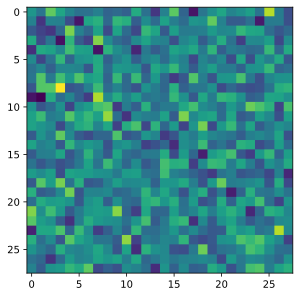

In [61]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models!

In [83]:
def function_to_train_the_model(labels_to_train):

  # Get training data
  indx_to_train = np.vectorize(cdata.class_to_idx.get)(labels_to_train)
  print(f"{labels_to_train} -> {indx_to_train}")
  dataT_mask = torch.tensor(np.isin(labels, indx_to_train))

  dataT = dataNorm[dataT_mask, :]

  # loss function (same for both phases of training)
  lossfun = nn.BCELoss()

  # create instances of the models
  dnet = discriminatorNet().to(device)
  gnet = generatorNet().to(device)

  # optimizers (same algo but different variables b/c different parameters)
  d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.001)
  g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.001)

  # this cell takes ~3 mins with 50k epochs
  num_epochs = 50000  # 50000

  losses = np.zeros((num_epochs, 2))
  disDecs = np.zeros((num_epochs, 2))  # disDecs = discriminator decisions

  for epochi in range(num_epochs):

    # create minibatches of REAL and FAKE images
    randidx = torch.randint(dataT.shape[0], (batchsize,))
    real_images = dataT[randidx, :].to(device)
    fake_images = gnet(torch.randn(batchsize, 64).to(device))  # output of generator

    # labels used for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real = dnet(real_images)  # REAL images into discriminator
    d_loss_real = lossfun(pred_real, real_labels)  # all labels are 1

    # forward pass and loss for FAKE pictures
    pred_fake = dnet(fake_images)  # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake, fake_labels)  # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi, 0] = d_loss.item()
    disDecs[epochi, 0] = torch.mean((pred_real > .5).float()).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet(torch.randn(batchsize, 64).to(device))
    pred_fake = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake, real_labels)
    losses[epochi, 1] = g_loss.item()
    disDecs[epochi, 1] = torch.mean((pred_fake > .5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # print out a status message
    if (epochi + 1) % 500 == 0:
      msg = f'Finished epoch {epochi + 1}/{num_epochs}'
      sys.stdout.write('\r' + msg)

  print("")
  return gnet, dnet, losses, disDecs, dataT

In [84]:
# First train with [Trouser, Sneaker, Pullover]
tsp_gnet, tsp_dnet, tsp_losses, tsp_disDecs, tsp_dataT = function_to_train_the_model(["Trouser", "Sneaker", "Pullover"])

# Then train with [Trouser, Sneaker, Sandal]
tss_gnet, tss_dnet, tss_losses, tss_disDecs, tss_dataT = function_to_train_the_model(["Trouser", "Sneaker", "Sandal"])

print("\nFinished training!")

['Trouser', 'Sneaker', 'Pullover'] -> [1 7 2]
Finished epoch 50000/50000
['Trouser', 'Sneaker', 'Pullover'] -> [1 7 2]
Finished epoch 50000/50000

Finished training!


In [101]:
def plot(losses, disDecs):
  fig,ax = plt.subplots(1,3,figsize=(18,5))

  def smooth(data):
    k = 300
    return np.convolve(data, np.ones(k) / k)

  ax[0].plot(smooth(losses[:, 0]))
  ax[0].plot(smooth(losses[:, 1]))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Model loss')
  ax[0].legend(['Discrimator','Generator'])
  # ax[0].set_xlim([4000,5000])

  ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
  ax[1].set_xlabel('Discriminator loss')
  ax[1].set_ylabel('Generator loss')

  ax[2].plot(disDecs)
  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('Probablity ("real")')
  ax[2].set_title('Discriminator output')
  ax[2].legend(['Real','Fake'])

  plt.show()

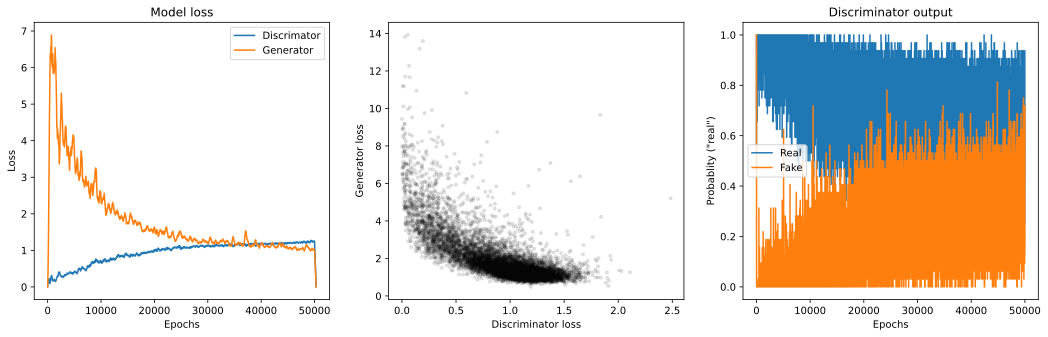

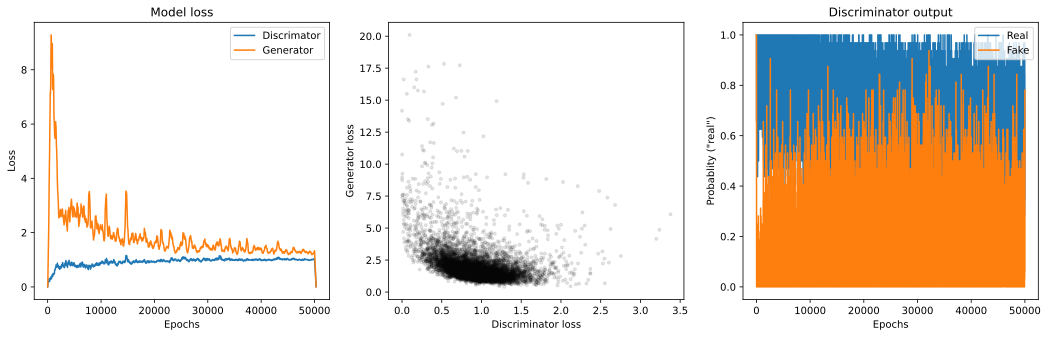

In [106]:
plot(tsp_losses, tsp_disDecs)
plot(tss_losses, tss_disDecs)

25.14% of fake samples where detected as real


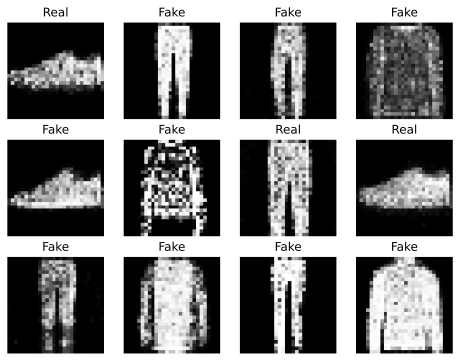

In [107]:
torch.manual_seed(0)

# generate the images from the generator network
tsp_gnet.eval()
fake_data = tsp_gnet(torch.randn(10000,64).to(device)).cpu()

tsp_dnet.eval()
fake_data_results = tsp_dnet(fake_data.to(device)).cpu().detach().numpy().flatten()

label_mapper = {
  False: "Fake",
  True: "Real"
}

fake_data_labels = np.vectorize(label_mapper.get)(fake_data_results > 0.5)
print(f"{100 * np.sum(fake_data_results > 0.5) / len(fake_data):.2f}% of fake samples where detected as real")

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.set_title(f"{fake_data_labels[i]}")
  ax.axis('off')

plt.show()

7.03% of fake samples where detected as real


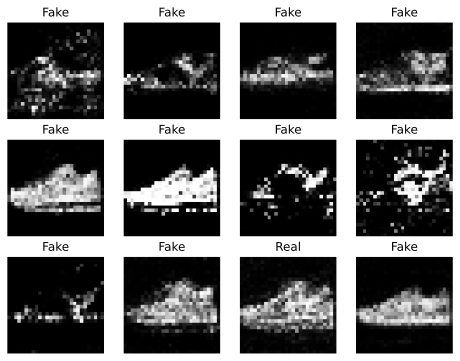

In [108]:
torch.manual_seed(0)

# generate the images from the generator network
tss_gnet.eval()
fake_data = tss_gnet(torch.randn(10000,64).to(device)).cpu()

tss_dnet.eval()
fake_data_results = tss_dnet(fake_data.to(device)).cpu().detach().numpy().flatten()

label_mapper = {
  False: "Fake",
  True: "Real"
}

fake_data_labels = np.vectorize(label_mapper.get)(fake_data_results > 0.5)
print(f"{100 * np.sum(fake_data_results > 0.5) / len(fake_data):.2f}% of fake samples where detected as real")

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.set_title(f"{fake_data_labels[i]}")
  ax.axis('off')

plt.show()